# New Signal Analysis and Baseline Model

This notebook calculates a baseline model and visualizes the impact of different models improving over the baseline.

## Features:
- Baseline model calculation with equal weights
- Model comparison visualizations
- Smoothed P(failure|Score) analysis
- Performance metrics comparison

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Setup and Configuration

In [3]:
# Define paths
base_path = Path('../')
model_outputs_path = base_path / 'model_outputs'
data_path = base_path / '../covenant/SampleCovenantData'

# Create baseline directory if it doesn't exist
baseline_path = model_outputs_path / 'baseline'
baseline_path.mkdir(exist_ok=True)

print(f"Base path: {base_path}")
print(f"Model outputs path: {model_outputs_path}")
print(f"Data path: {data_path}")
print(f"Baseline path: {baseline_path}")

Base path: ..
Model outputs path: ../model_outputs
Data path: ../../covenant/SampleCovenantData
Baseline path: ../model_outputs/baseline


## 2. Baseline Model Calculation

In [10]:
def get_baseline_model(col='weight'):
    """
    Get baseline model from common_data folder.
    
    Returns:
        pd.DataFrame: Baseline model with 'feature' and 'weight' columns
    """
    baseline_model = pd.read_csv('../common_data/scott_baseline.csv', index_col=0)

    return baseline_model['weight']

def calculate_baseline_model():
    """
    Calculate baseline model with equal weights for all features.
    
    Returns:
        tuple: (scores_df, weights_df) - baseline scores and weights
    """
    print("Calculating baseline model...")
    
    # Load signals data
    signals_file = data_path / 'binarySignalsPart00.csv'
    if not signals_file.exists():
        raise FileNotFoundError(f"Signals file not found: {signals_file}")
    
    # Load signals
    signals_df = pd.read_csv(signals_file, parse_dates=['signal_date'], date_format='%m/%d/%Y')
    print(f"Loaded {len(signals_df):,} signal records")
    
    # Get feature columns (exclude companyid and signal_date)
    feature_cols = [col for col in signals_df.columns if col not in ['companyid', 'signal_date']]
    print(f"Found {len(feature_cols)} features")
    
    # Get baseline weights
    equal_weights = get_baseline_model()
    
    # Calculate baseline scores
    scores = signals_df[['companyid', 'signal_date']].copy()
    scores['score'] = signals_df[feature_cols].dot(equal_weights).round(4)
    
    # Add failure labels (placeholder - would need actual failure data)
    # For now, we'll use a simple heuristic or load from existing model
    scores['fail'] = 0  # Placeholder
    
    # Create weights dataframe
    weights_df = pd.DataFrame({
        'Feature': feature_cols,
        'Weight': equal_weights.values
    })
    
    # Save baseline results
    scores.to_csv(baseline_path / 'scores.csv', index=False)
    weights_df.to_csv(baseline_path / 'weights.csv', index=False)
    
    print(f"Baseline model saved to {baseline_path}")
    print(f"Baseline scores range: {scores['score'].min():.4f} to {scores['score'].max():.4f}")
    
    return scores, weights_df

# Calculate baseline model
try:
    baseline_scores, baseline_weights = calculate_baseline_model()
    print("Baseline model calculated successfully!")
except Exception as e:
    print(f"Error calculating baseline model: {e}")
    baseline_scores, baseline_weights = None, None

Calculating baseline model...
Loaded 132,626 signal records
Found 25 features
Baseline model saved to ../model_outputs/baseline
Baseline scores range: 0.0238 to 0.8095
Baseline model calculated successfully!


## 3. Load All Model Data

In [34]:
def load_all_models():
    """Load all available model data including baseline"""
    models = {}
    
    # Model configurations
    model_configs = {
        # 'baseline': {
        #     'path': model_outputs_path / 'baseline',
        #     'color': 'gray',
        #     'linestyle': '--',
        #     'label': 'Baseline'
        # },
        'scottv1': {
            'path': model_outputs_path / 'scottv1',
            'color': 'blue',
            'linestyle': '-',
            'label': 'Scott v1'
        },
        'scottv2': {
            'path': model_outputs_path / 'scottv2',
            'color': 'red',
            'linestyle': '-',
            'label': 'Scott v2'
        },
        'scottv3': {
            'path': model_outputs_path / 'scottv3',
            'color': 'green',
            'linestyle': '-',
            'label': 'Scott v3'
        }
    }
    
    for model_name, config in model_configs.items():
        scores_file = config['path'] / 'scores.csv'
        weights_file = config['path'] / 'weights.csv'
        
        if scores_file.exists() and weights_file.exists():
            scores = pd.read_csv(scores_file)
            weights = pd.read_csv(weights_file)
            
            # Convert dates
            scores['signal_date'] = pd.to_datetime(scores['signal_date'])
            
            models[model_name] = {
                'scores': scores,
                'weights': weights,
                'config': config
            }
            print(f"Loaded {model_name}: {len(scores):,} records")
        else:
            print(f"Missing files for {model_name}")

    
    return models

# Load all models
model_data = load_all_models()
print(f"\nTotal models loaded: {len(model_data)}")

Loaded scottv1: 103,009 records
Loaded scottv2: 103,009 records
Loaded scottv3: 100,875 records

Total models loaded: 3


## 4. Model Comparison Visualizations

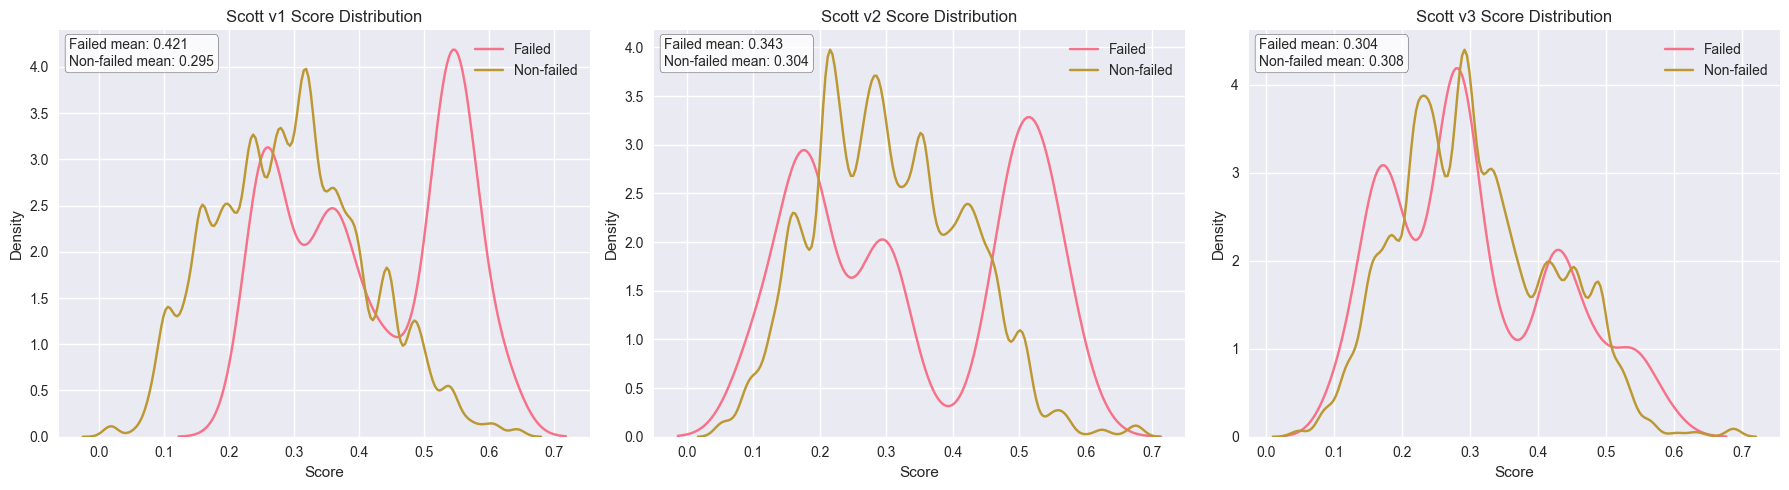

In [35]:
def plot_score_distributions(model_data_dict, skip_baseline=True):
    """Plot score distributions for all models"""
    
    if skip_baseline:
        model_data = {k: v for k, v in model_data_dict.items() if k != 'baseline'}
    else:
        model_data = model_data_dict

    n_models = len(model_data)
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))
    if len(model_data) == 1:
        axes = [axes]

    # Add fail to baseline model
    if not skip_baseline:
        model_data['baseline']['scores']['fail'] = model_data['baseline']['scores']['fail']

    for i, (model_name, data) in enumerate(model_data.items()):

        scores_df = data['scores']
        config = data['config']
        
        # Plot distributions
        sns.kdeplot(data=scores_df[scores_df['fail'] == 1], x='score', 
                   label='Failed', fill=False, common_norm=False, ax=axes[i])
        sns.kdeplot(data=scores_df[scores_df['fail'] == 0], x='score', 
                   label='Non-failed', fill=False, common_norm=False, ax=axes[i])
        
        axes[i].set_title(f'{config["label"]} Score Distribution')
        axes[i].set_xlabel('Score')
        axes[i].set_ylabel('Density')
        axes[i].legend()
        
        # Add statistics
        failed_mean = scores_df[scores_df['fail'] == 1]['score'].mean()
        non_failed_mean = scores_df[scores_df['fail'] == 0]['score'].mean()
        axes[i].text(0.02, 0.98, f'Failed mean: {failed_mean:.3f}\nNon-failed mean: {non_failed_mean:.3f}', 
                    transform=axes[i].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

plot_score_distributions(model_data)

## 5. Smoothed P(failure|Score) Analysis

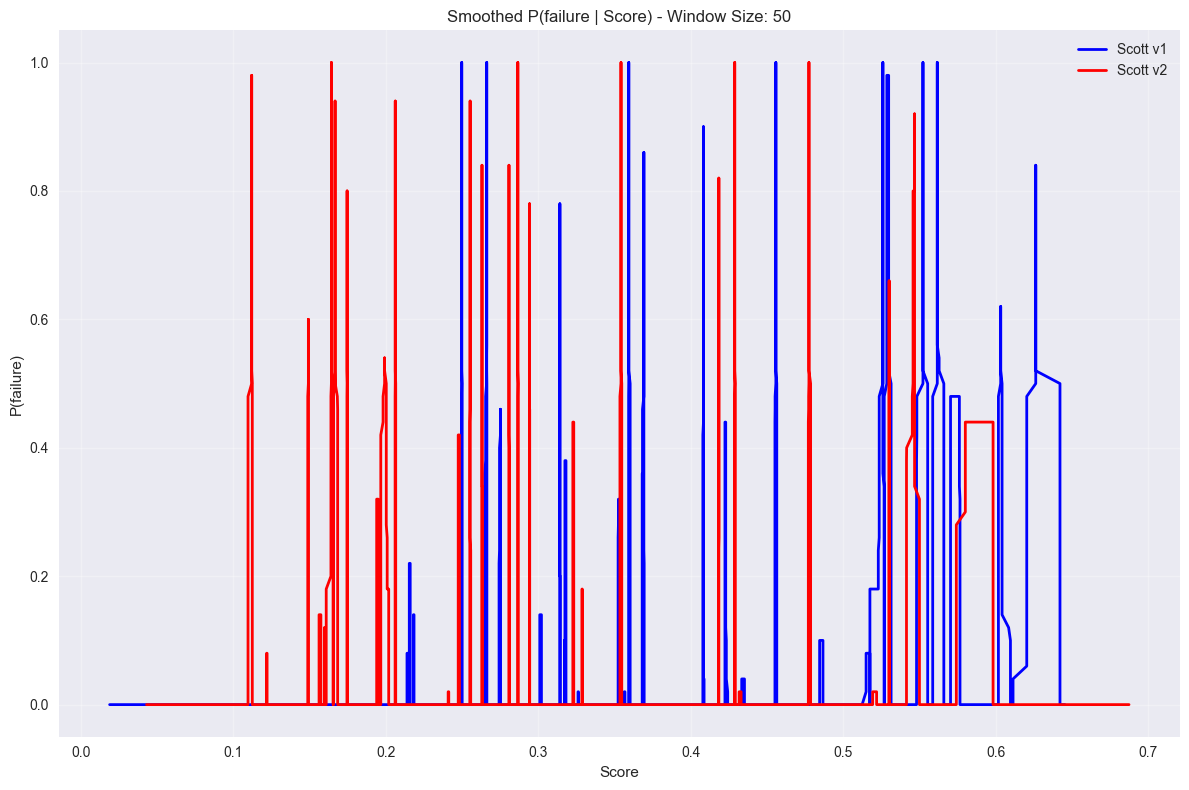

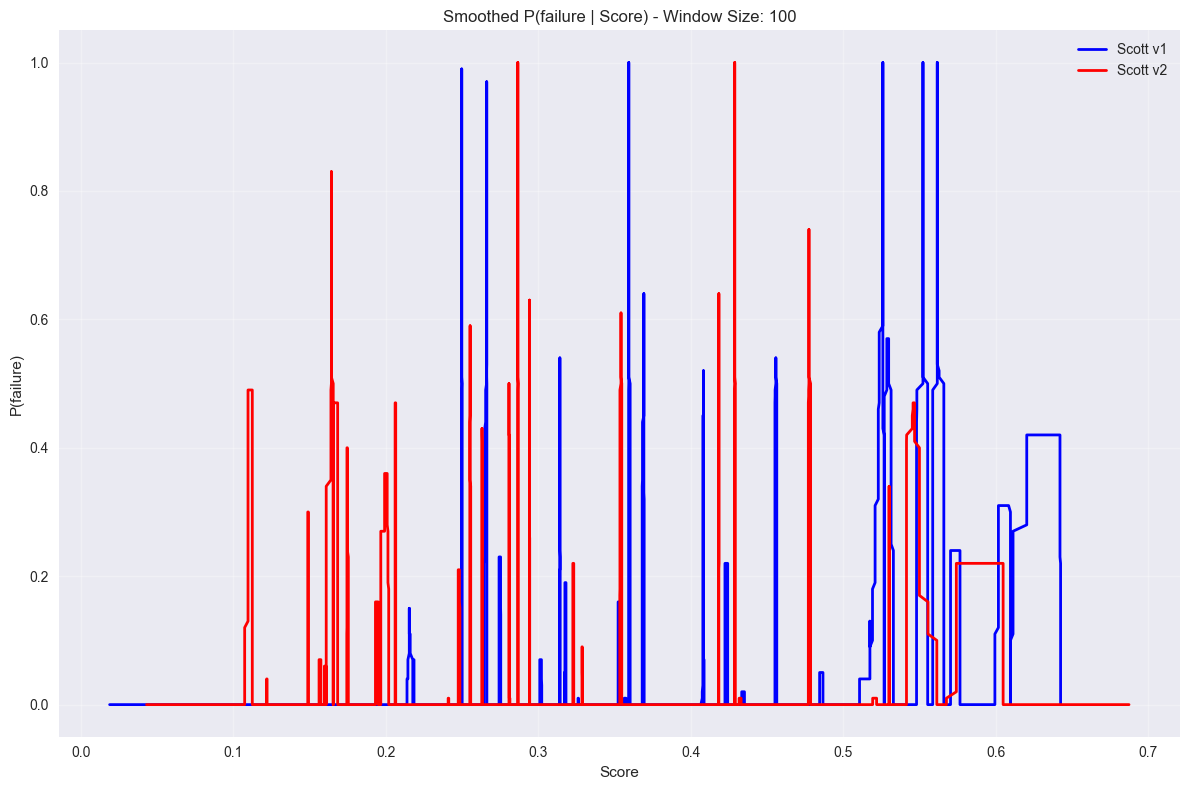

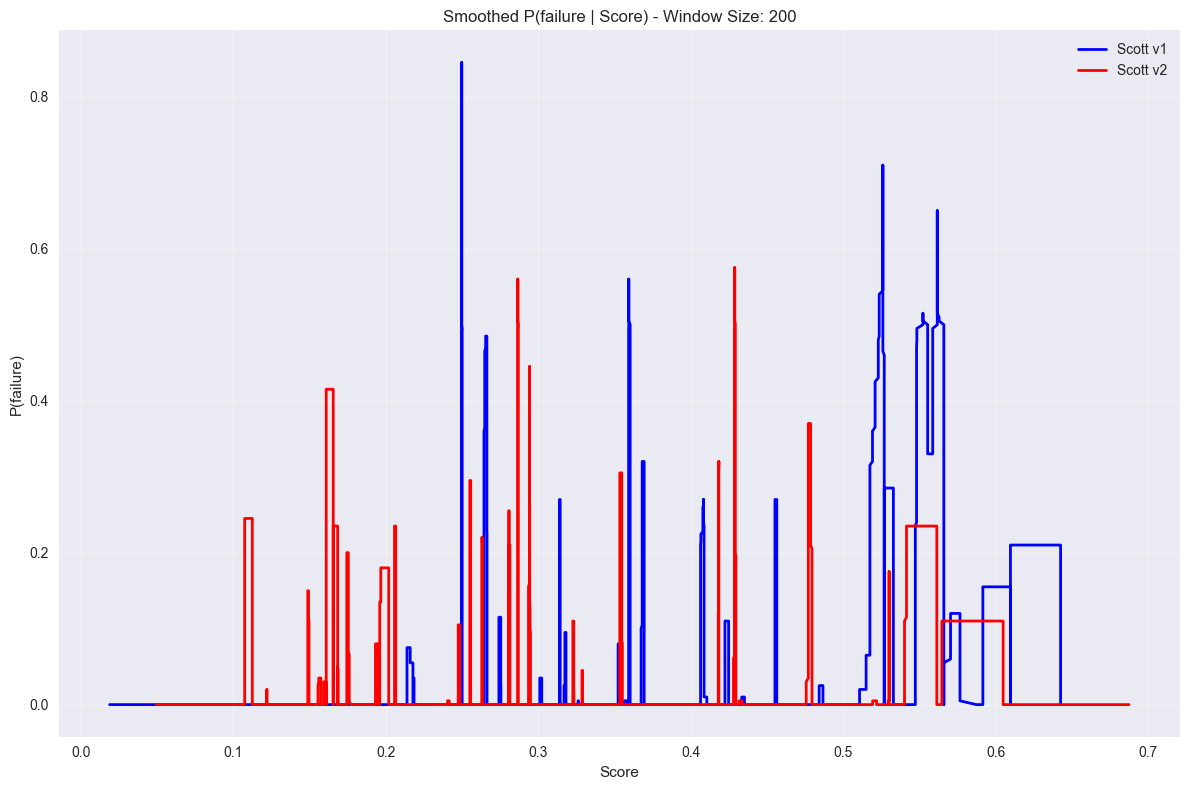

In [33]:
def calculate_smoothed_failure_probability(scores_df, window_size=100):
    """Calculate smoothed P(failure|Score) using rolling average"""
    # Sort by score
    df_sorted = scores_df.sort_values('score').reset_index(drop=True)
    
    # Calculate rolling average of failure probability
    rolling_avg = df_sorted['fail'].rolling(window=window_size, center=True).mean()
    
    return df_sorted['score'], rolling_avg

def plot_smoothed_failure_probability(model_data, window_size=100):
    """Plot smoothed P(failure|Score) for all models"""
    plt.figure(figsize=(12, 8))
    
    for model_name, data in model_data.items():
        scores_df = data['scores']
        config = data['config']
        
        scores, probs = calculate_smoothed_failure_probability(scores_df, window_size)
        
        plt.plot(scores, probs, 
                color=config['color'], 
                linestyle=config['linestyle'],
                linewidth=2, 
                label=f'{config["label"]}')
    
    plt.xlabel('Score')
    plt.ylabel('P(failure)')
    plt.title(f'Smoothed P(failure | Score) - Window Size: {window_size}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot with different window sizes
for window_size in [50, 100, 200]:
    plot_smoothed_failure_probability(model_data, window_size)

## 6. Performance Metrics Comparison

Performance Metrics:
          roc_auc  pr_auc  separation  failed_mean  non_failed_mean  \
baseline      NaN  0.5000         NaN          NaN           0.3956   
scottv1    0.9335  0.2723      2.1729       1.9575          -0.4256   
scottv2    0.4773  0.0146     -0.0298       0.3045           0.3080   

          score_range  score_std  
baseline       0.7857     0.1486  
scottv1        6.5729     1.1274  
scottv2        0.6446     0.1103  


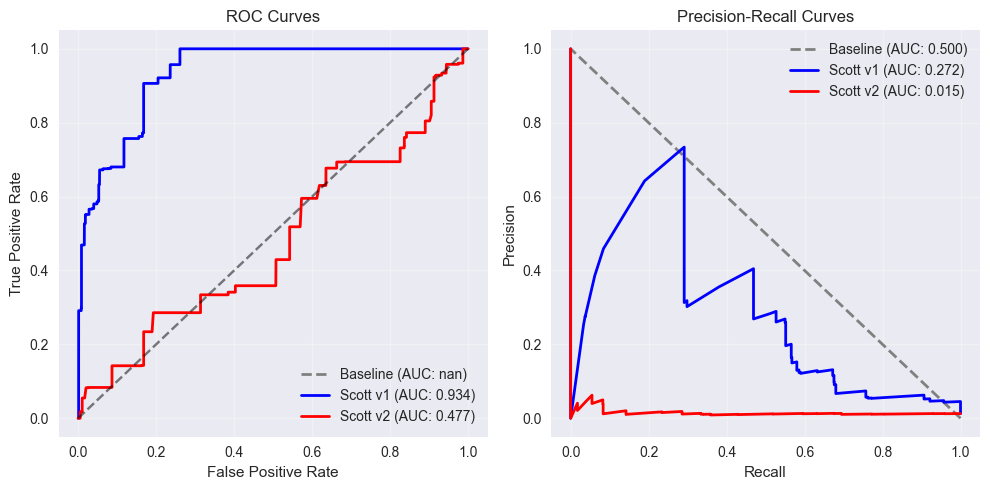

In [17]:
def calculate_performance_metrics(scores_df):
    """Calculate comprehensive performance metrics"""
    # ROC AUC
    roc_auc = roc_auc_score(scores_df['fail'], scores_df['score'])
    
    # PR AUC
    precision, recall, _ = precision_recall_curve(scores_df['fail'], scores_df['score'])
    pr_auc = auc(recall, precision)
    
    # Score statistics
    failed_scores = scores_df[scores_df['fail'] == 1]['score']
    non_failed_scores = scores_df[scores_df['fail'] == 0]['score']
    
    # Separation metric
    separation = (failed_scores.mean() - non_failed_scores.mean()) / np.sqrt((failed_scores.var() + non_failed_scores.var()) / 2)
    
    metrics = {
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'separation': separation,
        'failed_mean': failed_scores.mean(),
        'non_failed_mean': non_failed_scores.mean(),
        'score_range': scores_df['score'].max() - scores_df['score'].min(),
        'score_std': scores_df['score'].std()
    }
    
    return metrics

# Calculate metrics for all models
metrics_df = pd.DataFrame()

for model_name, data in model_data.items():
    metrics = calculate_performance_metrics(data['scores'])
    metrics_df[model_name] = metrics

metrics_df = metrics_df.T
print("Performance Metrics:")
print(metrics_df.round(4))

# Plot ROC curves
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
for model_name, data in model_data.items():
    scores_df = data['scores']
    config = data['config']
    
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(scores_df['fail'], scores_df['score'])
    plt.plot(fpr, tpr, color=config['color'], linestyle=config['linestyle'], 
             linewidth=2, label=f'{config["label"]} (AUC: {metrics_df.loc[model_name, "roc_auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
for model_name, data in model_data.items():
    scores_df = data['scores']
    config = data['config']
    
    precision, recall, _ = precision_recall_curve(scores_df['fail'], scores_df['score'])
    plt.plot(recall, precision, color=config['color'], linestyle=config['linestyle'], 
             linewidth=2, label=f'{config["label"]} (AUC: {metrics_df.loc[model_name, "pr_auc"]:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Model Improvement Analysis

=== MODEL IMPROVEMENTS OVER BASELINE ===

SCOTTV1 vs BASELINE:
  ROC AUC improvement: +nan
  PR AUC improvement: -0.2277
  Separation improvement: +nan

SCOTTV2 vs BASELINE:
  ROC AUC improvement: +nan
  PR AUC improvement: -0.4854
  Separation improvement: +nan



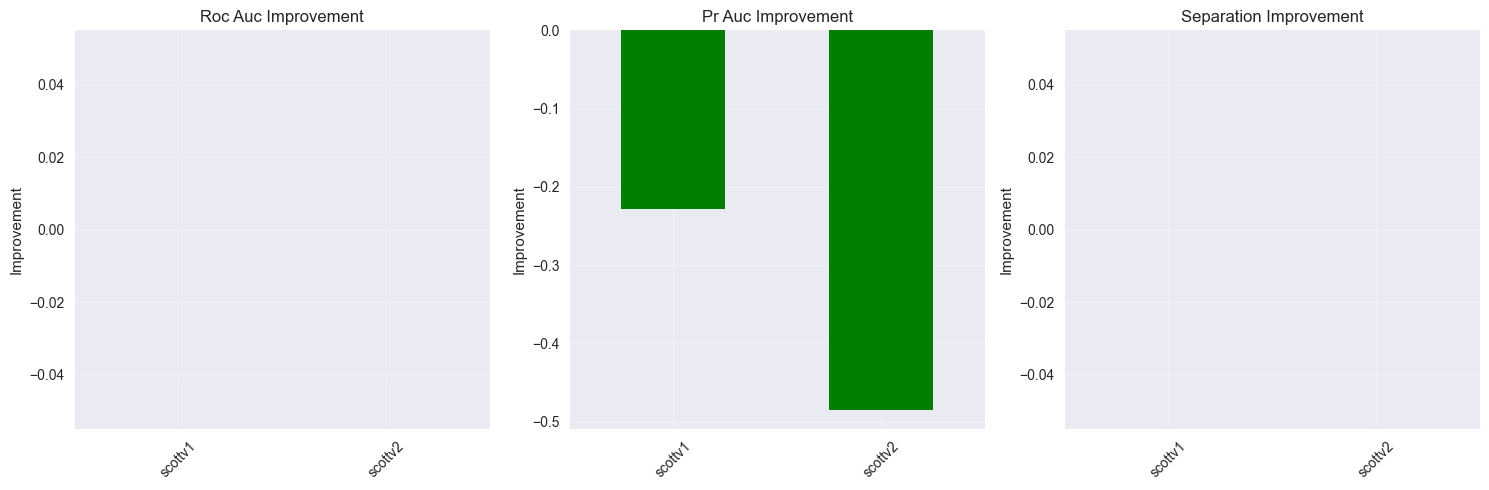

In [18]:
def analyze_model_improvements(model_data, baseline_model='baseline'):
    """Analyze improvements over baseline model"""
    if baseline_model not in model_data:
        print(f"Baseline model '{baseline_model}' not found in model_data")
        return
    
    baseline_metrics = metrics_df.loc[baseline_model]
    
    print("=== MODEL IMPROVEMENTS OVER BASELINE ===\n")
    
    improvements = {}
    for model_name in model_data.keys():
        if model_name != baseline_model:
            model_metrics = metrics_df.loc[model_name]
            
            roc_improvement = model_metrics['roc_auc'] - baseline_metrics['roc_auc']
            pr_improvement = model_metrics['pr_auc'] - baseline_metrics['pr_auc']
            separation_improvement = model_metrics['separation'] - baseline_metrics['separation']
            
            improvements[model_name] = {
                'roc_auc_improvement': roc_improvement,
                'pr_auc_improvement': pr_improvement,
                'separation_improvement': separation_improvement
            }
            
            print(f"{model_name.upper()} vs {baseline_model.upper()}:")
            print(f"  ROC AUC improvement: {roc_improvement:+.4f}")
            print(f"  PR AUC improvement: {pr_improvement:+.4f}")
            print(f"  Separation improvement: {separation_improvement:+.4f}")
            print()
    
    # Plot improvements
    if improvements:
        improvement_df = pd.DataFrame(improvements).T
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        for i, metric in enumerate(['roc_auc_improvement', 'pr_auc_improvement', 'separation_improvement']):
            improvement_df[metric].plot(kind='bar', ax=axes[i], color='green')
            axes[i].set_title(f'{metric.replace("_", " ").title()}')
            axes[i].set_ylabel('Improvement')
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return improvements

# Analyze improvements
improvements = analyze_model_improvements(model_data)

## 8. Summary and Insights

In [19]:
print("=== NEW SIGNAL ANALYSIS SUMMARY ===\n")

# Summary statistics
for model_name, data in model_data.items():
    scores_df = data['scores']
    config = data['config']
    
    print(f"{config['label']}:")
    print(f"  Total records: {len(scores_df):,}")
    print(f"  Failed companies: {scores_df['fail'].sum():,}")
    print(f"  Non-failed companies: {(scores_df['fail'] == 0).sum():,}")
    print(f"  Score range: {scores_df['score'].min():.3f} to {scores_df['score'].max():.3f}")
    
    if model_name in metrics_df.index:
        print(f"  ROC AUC: {metrics_df.loc[model_name, 'roc_auc']:.3f}")
        print(f"  PR AUC: {metrics_df.loc[model_name, 'pr_auc']:.3f}")
        print(f"  Separation: {metrics_df.loc[model_name, 'separation']:.3f}")
    
    print()

print("=== KEY INSIGHTS ===")
print("1. The baseline model provides a reference point for comparing more sophisticated models")
print("2. Smoothed P(failure|Score) curves show how well each model separates failed from non-failed companies")
print("3. ROC AUC and PR AUC provide quantitative measures of model performance")
print("4. Model improvements over baseline indicate the value of feature engineering and optimization")
print("5. The separation metric quantifies the distance between failed and non-failed score distributions")

=== NEW SIGNAL ANALYSIS SUMMARY ===

Baseline:
  Total records: 132,626
  Failed companies: 0
  Non-failed companies: 132,626
  Score range: 0.024 to 0.809
  ROC AUC: nan
  PR AUC: 0.500
  Separation: nan

Scott v1:
  Total records: 103,009
  Failed companies: 1,260
  Non-failed companies: 101,749
  Score range: -2.825 to 3.748
  ROC AUC: 0.934
  PR AUC: 0.272
  Separation: 2.173

Scott v2:
  Total records: 100,875
  Failed companies: 1,260
  Non-failed companies: 99,615
  Score range: 0.043 to 0.688
  ROC AUC: 0.477
  PR AUC: 0.015
  Separation: -0.030

=== KEY INSIGHTS ===
1. The baseline model provides a reference point for comparing more sophisticated models
2. Smoothed P(failure|Score) curves show how well each model separates failed from non-failed companies
3. ROC AUC and PR AUC provide quantitative measures of model performance
4. Model improvements over baseline indicate the value of feature engineering and optimization
5. The separation metric quantifies the distance between 